In [13]:
from extractEvents import AnimalEventDetector
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pandas as pd
from pydub import AudioSegment
import os
from scipy.signal import correlate

In [16]:
file_name  = './bird_audio_track.m4a'
amplitude_threshold = 0.05
min_event_duration = 10_000
sample_rate = 44100
band = (370, 400)
ema_alpha=0.01

In [17]:
detector = AnimalEventDetector(amplitude_threshold, min_event_duration, sample_rate, band, ema_alpha)
detector.load_audio(file_name)
events = detector.detect_events(filter=False)
events

[(417965, 897965), (7776365, 8256365), (8736523, 9216523)]

Text(0.5, 1.0, 'Identifying Bird Activity')

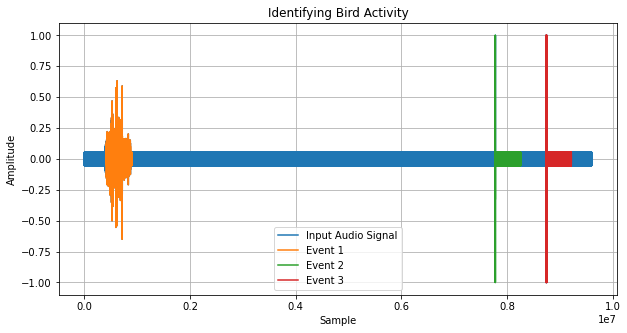

In [35]:
rng = np.arange(detector.audio_array.shape[0])
plt.figure(figsize=(10,5))
plt.plot(rng, detector.audio_array, label='Input Audio Signal')
for i, event in enumerate(detector.events):
    plt.plot(rng[event[0]:event[1]], detector.audio_array[event[0]:event[1]], label=f'Event {i+1}')
plt.grid()
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Identifying Bird Activity')

In [19]:
def load_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    max_amplitude = np.max(np.abs(samples))
    if max_amplitude > 0:
        samples = samples / max_amplitude
    return samples

path = '../data'
files = os.listdir(path)
np.random.seed(4810)
np.random.shuffle(files)
random_animals = files[:5] + ['Puffinus_nativitatis.mp3', 'Falco_peregrinus.mp3', 'Cyanocitta_cristata.mp3']

correlations = {event[0]: {} for event in detector.events}
normal_correlations = {event[0]: {} for event in detector.events}
filtered_correlations = {event[0]: {} for event in detector.events}
normal_filtered_correlations = {event[0]: {} for event in detector.events}

for file in random_animals:
    animal = file.split('.')[0].replace('_', ' ')
    try:
        sample = load_audio(path+'/'+file)
        sample_filtered = detector.filter_frequencies(sample)
        for event in detector.events:
            signal = detector.audio_array[event[0]:event[1]]
            correlation = correlate(signal, sample, mode='full')
            correlations[event[0]][animal] = np.max(correlation)
            normal_correlations[event[0]][animal] = np.max(correlation)/(np.std(signal)*np.std(sample))

            signal_filtered = detector.filter_frequencies(signal)
            filtered_correlation = correlate(signal_filtered, sample_filtered, mode='full')
            filtered_correlations[event[0]][animal] = np.max(filtered_correlation)
            normal_filtered_correlations[event[0]][animal] = np.max(filtered_correlation)/(np.std(signal_filtered)*np.std(sample_filtered))
    except Exception as e:
        print(animal)
        print(e)

In [20]:
df = pd.DataFrame(correlations)
df.to_csv('../correlations_new.csv')
df_norm = pd.DataFrame(normal_correlations)
df_norm.to_csv('../correlations_new_normal.csv')
df_f = pd.DataFrame(filtered_correlations)
df_f.to_csv('../correlations_new_f.csv')
df_f_norm = pd.DataFrame(normal_filtered_correlations)
df_f_norm.to_csv('../correlations_new_f_normal.csv')

In [37]:
df = pd.read_csv('../correlations_new.csv', index_col=0)
df_norm = pd.read_csv('../correlations_new_normal.csv', index_col=0)
df_f = pd.read_csv('../correlations_new_f.csv', index_col=0)
df_f_norm = pd.read_csv('../correlations_new_f_normal.csv', index_col=0)

results = {
    'Ground Truth': {'7776365': 'Puffinus nativitatis', '8736523': 'Cyanocitta cristata', '417965': 'Falco peregrinus'},
    'Correlation': df.idxmax(),
    'Filtered Correlation': df_f.idxmax(),
    'Normalized Correlation': df_norm.idxmax(),
    'Filtered & Normalized Correlation': df_f_norm.idxmax(),
    'True Starting Time': {'7776365': 81, '8736523': 91, '417965': 4}
}
results_frame = pd.DataFrame(results)
results_frame['Estimated Starting Time'] = (100 * results_frame.index.astype(int)/rng[-1])
results_frame.rename({'7776365': 'Event 2', '8736523': 'Event 3', '417965': 'Event 1'}).sort_index()

,Ground Truth,Correlation,Filtered Correlation,Normalized Correlation,Filtered & Normalized Correlation,True Starting Time,Estimated Starting Time
Event 1,Falco peregrinus,Cyanocitta cristata,Numenius tahitiensis,Cyanocitta cristata,Puffinus nativitatis,4,4.353803
Event 2,Puffinus nativitatis,Falco peregrinus,Numenius tahitiensis,Puffinus nativitatis,Puffinus nativitatis,81,81.003811
Event 3,Cyanocitta cristata,Falco peregrinus,Numenius tahitiensis,Falco peregrinus,Cyanocitta cristata,91,91.005457


In [39]:
results_frame.rename({'7776365': 'Event 2', '8736523': 'Event 3', '417965': 'Event 1'})[['True Starting Time', 'Estimated Starting Time']].sort_index().T

,Event 1,Event 2,Event 3
True Starting Time,4.000000,81.000000,91.000000
Estimated Starting Time,4.353803,81.003811,91.005457


In [44]:
results_frame.rename({'7776365': 'Event 2', '8736523': 'Event 3', '417965': 'Event 1'})[
    ['Ground Truth', 'Correlation', 'Filtered Correlation', 'Normalized Correlation', 'Filtered & Normalized Correlation']
].sort_index().T

,Event 1,Event 2,Event 3
Ground Truth,Falco peregrinus,Puffinus nativitatis,Cyanocitta cristata
Correlation,Cyanocitta cristata,Falco peregrinus,Falco peregrinus
Filtered Correlation,Numenius tahitiensis,Numenius tahitiensis,Numenius tahitiensis
Normalized Correlation,Cyanocitta cristata,Puffinus nativitatis,Falco peregrinus
Filtered & Normalized Correlation,Puffinus nativitatis,Puffinus nativitatis,Cyanocitta cristata
